In [1]:
!pip install easyocr
!pip install pymorphy2
!pip install EasyOCR
!pip install --ignore-installed PyYAML
!pip install natsort
!pip install PyYAML
!pip install opencv-python-headless==4.5.4.58
!pip install pymorphy2

  Using cached PyYAML-6.0-cp39-cp39-win_amd64.whl (151 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.


In [2]:
import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw
import easyocr
import re
import pymorphy2
from tqdm import tqdm
import os
import sys
import csv
import json
from PIL import Image, ImageFile, ImageSequence, ImageEnhance, ImageChops, ImageFilter, ImageFont, ImageDraw

import re
import cv2
morph = pymorphy2.MorphAnalyzer()
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
reader = easyocr.Reader(['ru'], recog_network='custom_example')

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Format

In [4]:
#обрезка изображения
def crop_image(image: Image,
               persent: float):
    return image.crop(box=(0, 0, image.size[0], image.size[1]*persent))

In [5]:
def image_transforming(image: Image): #-> Image:
    """This method transforms images:
    - if image is color it turn it to cray mode
    - if image is gray it enhances image contras, brigteness and sharpness
    - if image is binary it does nothing
    NOTE: in this version transforming params are hardcoded
    """
    # code below does image coverting to gray mode and represents it as np.array and increase Contrast
    image = image.convert("L")
    image = ImageEnhance.Contrast(image).enhance(2) #max-?
    # image = ImageEnhance.Sharpness(image).enhance(2) #нужна ли четкость?
    cv_image = np.array(image) #матрица изображения
    # the lines below instantiate kernels for a base table cleanup and for finish cleanup
    base_kernel = np.array(cv_image).shape[1] // 40 #40?

    # Прямоугольное ядро
    ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, base_kernel)) #размер ядра вертикаль # ядро для отброса шума??
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (base_kernel, 1)) #горизонталь
    cleanup_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    # the code below markup table lines and makes them white
    #пороговое значение для деление на бел/черн цвета #почему не adaptiveThreshold
    inv_bin_image = cv2.threshold(
        (255 - cv_image), 110, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU #OTSU - автоматический выбор порога
    )[1]
    inv_bin_image_vert = cv2.morphologyEx(inv_bin_image, cv2.MORPH_OPEN, ver_kernel) #removing noise
    inv_bin_image_hor = cv2.morphologyEx(inv_bin_image, cv2.MORPH_OPEN, hor_kernel) #removing noise
    inv_bin_table_image = ImageChops.add(
        Image.fromarray(inv_bin_image_vert), Image.fromarray(inv_bin_image_hor) #добавляет два изображения, разделяя результат по масштабу и добавляя смещение
    )

    #увеличение размера элементов
    bolt_inv_bin_table_image = cv2.dilate(
        np.array(inv_bin_table_image), cleanup_kernel, iterations=1
    )
    bolt_inv_bin_table_image = cv2.dilate(
        np.array(bolt_inv_bin_table_image), cleanup_kernel, iterations=1
    )

    return ImageChops.lighter(
        Image.fromarray(cv_image), Image.fromarray(bolt_inv_bin_table_image)
    ) #новое изображение, содержащее более светлые значения

In [6]:
def add2str(data, num):
    return [data[num][1],
            round(data[num][0][0][0]), #x
            round(data[num][0][0][1]), #y
            int(round(data[num][2], 2)*100)
            ]

In [7]:
def format(data):

    lines = list()
    new_str = list()

    new_str.append(add2str(data, 0))

    for idx, element in enumerate(data):
        if idx > 0 and data[idx-1][0][0][0] < data[idx][0][0][0]:
            new_str.append(add2str(data, idx))
        elif idx > 0 and data[idx-1][0][0][0] > data[idx][0][0][0]:
            lines.append(new_str)
            new_str = list()
            new_str.append(add2str(data, idx))

    return lines

In [8]:
# Draw bounding boxes
def draw_boxes(image, bounds, color='yellow', width=2):

    image = Image.open(image).convert('RGB')
    draw = ImageDraw.Draw(image)

    for bound in bounds:
        p0, p1, p2, p3 = bound[0]
        draw.line([*p0, *p1, *p2, *p3, *p0], fill=color, width=width)
    return image

In [9]:
def is_significant(token, not_significant_tag: str="UNKN", not_significant_score: float=.7):

    token = morph.parse(token.lower())[0]

    return int((not_significant_tag not in token.tag) & (
            len(token.methods_stack)==1))


def elements_with_significant_tokens(document: list):

    """It solves the significant tokens score.
    The token is significant for NLP if it was recognized by
    the MorphAnalyzer with a rate more or equal to the not_significant_score value
    """

    res = list()
    incorrect_words = list()
    correct_words = list()
    text_str = []
    check_text = []
    text = []

    text_str.extend([elem[0] for tabs_elem in document for elem in tabs_elem if elem[0] != ''])
    check_text.extend([word for text in text_str for word in re.sub(r'\)', ' )', re.sub(r'\(', '( ', re.sub('[^а-яА-ЯЁёIV01234567890\-\=() ]', '', text))).split()])

    #for easyOSR
    for word in check_text:
        try:
            if word[1] == word[1].upper() and word[0] == 'к' and word[-1] == 'к':
                text.append(re.sub('к', '', word, 1)[:-1])
            elif word[1] == word[1].upper() and word[0] == 'к':
                text.append(re.sub('к', '', word, 1))
            else:
                text.append(word)
        except:
            text.append(word)

            continue

    incorrect_words.extend([token for token in text if is_significant(token)==False])
    correct_words.extend([token for token in text if is_significant(token)])

    numbers = sum([is_significant(token) for token in text])

    print("Неверно прочитанные слова: ", incorrect_words)
    #print("Верно прочитанные слова: ", correct_words)
    print("Кол-во подтверженных лемм: ", numbers)
    print("Кол-во найденных лемм: ", len(check_text))

    return "Доля подтвержденных лемм: ", round(numbers/len(check_text), 2)

In [10]:
#image = Image.open(image)
#draw_boxes(image, result_1).save('result_обычный_текст_без_фильтра.jpg')

TEST

In [11]:
image = 'table_without_signature.jpg'
image = Image.open(image)
result_custom = reader.readtext(image)
result_custom

[([[913, 159], [1743, 159], [1743, 208], [913, 208]],
  " йхжнмдпмююйнлоюмжю кынрюж' Н(",
  0.3648921248526688),
 ([[546, 204], [2097, 204], [2097, 261], [546, 261]],
  "Атфвкдпрйю'ужхюмрнбююнсцдснрсыёюсвнг.ёйнмцжбхжирюё1гдйапю20д",
  0.1787898612621805),
 ([[759, 286], [1893, 286], [1893, 355], [759, 355]],
  'нсцыснГбжзымжжГДмызмъфрРДгРсб',
  0.23161100183943134),
 ([[1172, 355], [1383, 355], [1383, 397], [1172, 397]],
  'ё42016внг',
  0.3949237428495602),
 ([[1662, 409], [1976, 409], [1976, 465], [1662, 465]],
  'УннплдсонНг',
  0.2643258397151122),
 ([[2073, 410], [2230, 410], [2230, 455], [2073, 455]],
  '0710004',
  0.8723411067261794),
 ([[1535, 461], [1628, 461], [1628, 510], [1535, 510]],
  'Гдс',
  0.4286637306213379),
 ([[1640, 463], [1972, 463], [1972, 507], [1640, 507]],
  'цжркн\\лдрюх\\внг(',
  0.6477603651265775),
 ([[1994, 460], [2041, 460], [2041, 501], [1994, 501]],
  '31',
  0.9987185101384661),
 ([[2084, 460], [2134, 460], [2134, 504], [2084, 504]],
  '12',
  0.986

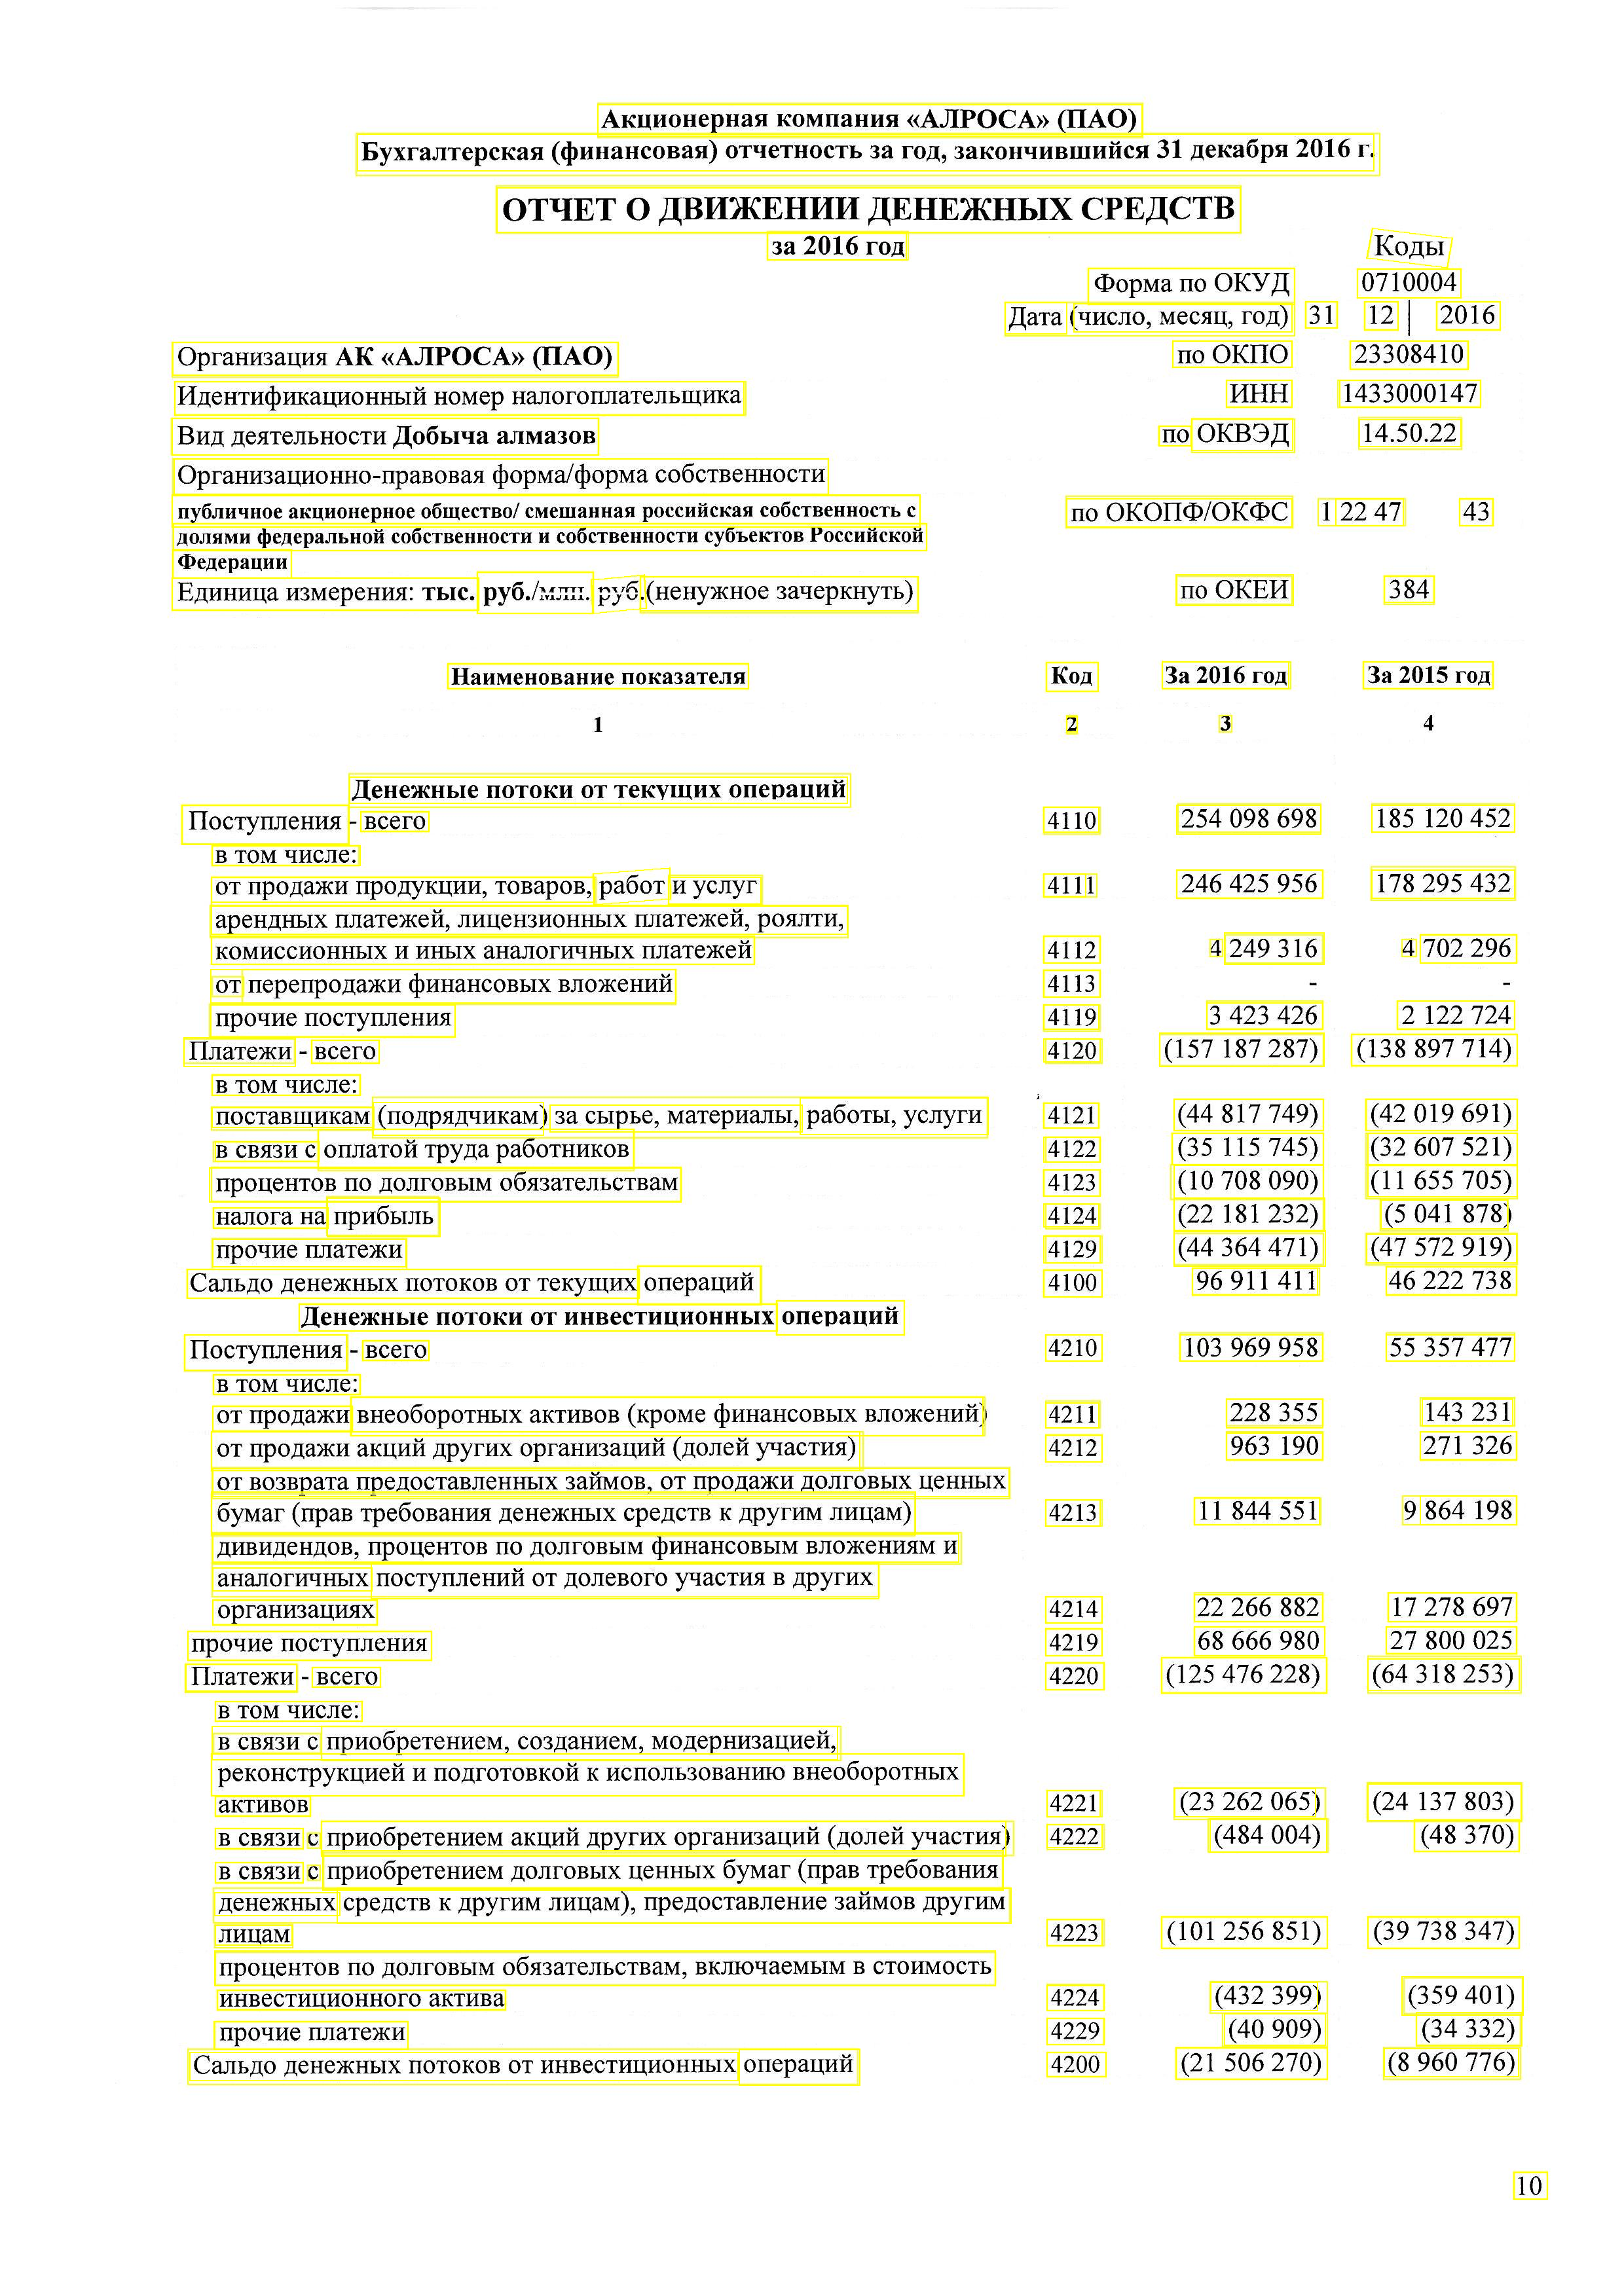

In [12]:
draw_boxes('table_without_signature.jpg', result_custom)

In [13]:
format(result_custom)

[[[" йхжнмдпмююйнлоюмжю кынрюж' Н(", 913, 159, 36]],
 [["Атфвкдпрйю'ужхюмрнбююнсцдснрсыёюсвнг.ёйнмцжбхжирюё1гдйапю20д",
   546,
   204,
   18],
  ['нсцыснГбжзымжжГДмызмъфрРДгРсб', 759, 286, 23],
  ['ё42016внг', 1172, 355, 39],
  ['УннплдсонНг', 1662, 409, 26],
  ['0710004', 2073, 410, 87]],
 [['Гдс', 1535, 461, 43],
  ['цжркн\\лдрюх\\внг(', 1640, 463, 65],
  ['31', 1994, 460, 100],
  ['12', 2084, 460, 99],
  ['2016', 2194, 460, 100]],
 [["Ннпвёмжёдхжю й кынр ' Н(", 264, 522, 16],
  ['онНОН', 1791, 520, 96],
  ['23308410', 2062, 520, 93]],
 [['Жгдмсжужйдхжнммъимнлдпмкнвноксдкыхжйд', 267, 582, 40],
  ['ЖММ', 1873, 580, 100],
  ['1433000147', 2046, 580, 99]],
 [['бжггдюсдкымнрсжгнаъцклёнб', 263, 638, 45],
  ['он', 1770, 650, 100],
  ['НнБЬг', 1820, 639, 20],
  ['14-50-22', 2076, 640, 100]],
 [['Нвёмжёахжнмн,пднбаюунплд.унплдрнарсбдммнрсж', 266, 700, 13]],
 [['стакжцмдюйхжндпмрднамдрбнрдюммююйнрржирйюрнарсбдммнрсыр', 263, 755, 8],
  ['онНйНОУ.НЙУРэ', 1629, 761, 38],
  ['2247', 2040, 761, 6

In [14]:
elements_with_significant_tokens(format(result_custom))

Неверно прочитанные слова:  ['йхжнмдпмююйнлоюмжю', 'кынрюж', 'Н(', 'Атфвкдпрйюужхюмрнбююнсцдснрсыёюсвнгёйнмцжбхжирюё1гдйапю20д', 'нсцыснГбжзымжжГДмызмъфрРДгРсб', 'ё42016внг', 'УннплдсонНг', 'Гдс', 'цжркнлдрюхвнг(', 'Ннпвёмжёдхжю', 'й', 'кынр', 'Н(', 'онНОН', 'Жгдмсжужйдхжнммъимнлдпмкнвноксдкыхжйд', 'ЖММ', 'бжггдюсдкымнрсжгнаъцклёнб', 'НнБЬг', '14-50-22', 'Нвёмжёахжнмнпднбаюунплдунплдрнарсбдммнрсж', 'стакжцмдюйхжндпмрднамдрбнрдюммююйнрржирйюрнарсбдммнрсыр', 'онНйНОУНЙУРэ', 'гнкюлждгдпкымнрнарсбдммнрсжжрнарсбдммнрсжртащдйснбнрржирйни', 'цдгдпхжж', 'Пгжмжхжёлдпдмжю-сър', 'па-кк--', 'мдмтзмндёацдпймтсы', 'онНыж', 'ожлдмнбюмждонйюёюсдкюэ', 'йнг', 'ё42016внг', 'ё42015внг', 'Гдмдзмъдонснйжнссдйтшжфнодпюхжи', 'онрстодмжю', 'брдвн', 'бснлжркд', 'нсопнгдзжопнгтйхжжснбюпнб', 'жрктв', 'ёпдмгмъфоксдздикжхдмёжнммъфксдздипнюксж', 'нссодпдопнгзжужмдмрнбъфбкнздмжи', 'опнцждсонрстокдмжю', 'Окюсдзж', 'брдвн', '157187287(', '138897714(', 'бснлжркд', 'онгпюгцжйёлё', 'ё4ръпыдлдсдпждкъ', '44817749(', '420196

('Доля подтвержденных лемм: ', 0.36)

In [15]:
reader = easyocr.Reader(['ru'])
result = reader.readtext(image)
elements_with_significant_tokens(format(result))

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


Неверно прочитанные слова:  ['АЛРОСАх', 'ПАО', 'З1', '2О1б', '2О16', 'ОКУД', 'АК', 'ПАО', 'ОКПо', 'ОКВЭД', 'ОкопФокфс', 'рубнжн', 'ОКеИ', '2О16', '2О15']
Кол-во подтверженных лемм:  481
Кол-во найденных лемм:  496


('Доля подтвержденных лемм: ', 0.97)